In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from glob import glob
import datetime
import tensorflow as tf
from tensorflow import keras
from keras import layers

import tensorflow_addons as tfa

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# HPE account when...
# Set GPU memory use to dynamic
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [3]:
BATCH_SIZE = 1
NUM_CLASSES = 3
NUM_SUBIMAGE = 20
SEED = 69
INPUT_SHAPE = (160, 160)

img_paths = glob("raws/*")
mask_paths = glob("out/*")

dataset_size = len(img_paths)

In [4]:
def load_image(image_path, mask_path):
    image = tf.cast(tf.image.decode_png(tf.io.read_file(image_path), channels=3), dtype="float32") / 255.0
    image.set_shape((None, None, 3))
    image = tf.image.resize(images=image, size=INPUT_SHAPE)

    mask = tf.image.decode_png(tf.io.read_file(mask_path), channels=1)
    mask.set_shape((None, None, 1))
    mask = tf.image.resize(images=mask, size=INPUT_SHAPE)
    return image, mask

def augment_image(image, mask):
    print(image, mask)
    return tf.data.Dataset.from_tensors(([image], [mask]))
            

def data_generator(image_list, mask_list):
    # starts off as two sets of strings
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    # then it becomes two sets of images
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    # expand said sets of images to bigger sets if we have the train set
    # dataset = dataset.flat_map(augment_image)
    # batchify it
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

In [5]:
train_dataset = data_generator(img_paths[1:], mask_paths[1:])
val_dataset = data_generator(img_paths[0:1], mask_paths[0:1])

print("Train Dataset:", train_dataset, "len =", tf.data.experimental.cardinality(train_dataset).numpy())
print("Val Dataset:", val_dataset, "len =", tf.data.experimental.cardinality(val_dataset).numpy())

Train Dataset: <BatchDataset shapes: ((1, 160, 160, 3), (1, 160, 160, 1)), types: (tf.float32, tf.float32)> len = 4
Val Dataset: <BatchDataset shapes: ((1, 160, 160, 3), (1, 160, 160, 1)), types: (tf.float32, tf.float32)> len = 1


In [6]:
# data statistics
num_pixels = INPUT_SHAPE[0] * INPUT_SHAPE[1]
for e in train_dataset.as_numpy_iterator():
    arr = np.array(e[1], dtype="uint8")
    print(arr.shape)
    print(f"% of shadow pixels: {np.count_nonzero(arr == 0) / num_pixels}")
    print(f"% of CCA pixels: {np.count_nonzero(arr == 1) / num_pixels}")
    print(f"% of unclassed pixels: {np.count_nonzero(arr == 2) / num_pixels}")

(1, 160, 160, 1)
% of shadow pixels: 0.7785546875
% of CCA pixels: 0.094140625
% of unclassed pixels: 0.1273046875
(1, 160, 160, 1)
% of shadow pixels: 0.665703125
% of CCA pixels: 0.1802734375
% of unclassed pixels: 0.1540234375
(1, 160, 160, 1)
% of shadow pixels: 0.6831640625
% of CCA pixels: 0.1504296875
% of unclassed pixels: 0.16640625
(1, 160, 160, 1)
% of shadow pixels: 0.6466015625
% of CCA pixels: 0.072421875
% of unclassed pixels: 0.2809765625


In [7]:
# off-the-shelf model retrieved from https://keras.io/examples/vision/oxford_pets_image_segmentation/
def get_unet_model(img_shape, num_classes):
    inputs = keras.Input(shape=img_shape)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    return keras.Model(inputs, outputs)

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

In [8]:
# off-the-shelf model retrieved from https://keras.io/examples/vision/deeplabv3_plus/
def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
    x = layers.Conv2D(num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding, use_bias=use_bias, kernel_initializer=keras.initializers.HeNormal())(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",)(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def get_deeplabv3_model(img_shape, num_classes):
    model_input = keras.Input(shape=img_shape)
    resnet50 = keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=model_input)
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(size=(img_shape[0] // 4 // x.shape[1], img_shape[0] // 4 // x.shape[2]), interpolation="bilinear")(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(size=(img_shape[0] // x.shape[1], img_shape[0] // x.shape[2]),interpolation="bilinear",)(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session

<function keras.backend.clear_session()>

In [9]:
model = get_unet_model(INPUT_SHAPE + (3,), num_classes=NUM_CLASSES)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
loss_function = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
spaAcc = tf.keras.metrics.SparseCategoricalAccuracy()
acc = tf.keras.metrics.Accuracy()

In [11]:
class SparseMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self, y_true=None, y_pred=None, num_classes=None, name=None, dtype=None):
    super(SparseMeanIoU, self).__init__(num_classes = num_classes, name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

In [14]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=loss_function, metrics=[spaAcc, SparseMeanIoU(num_classes=NUM_CLASSES)])

In [15]:
# train metric displays are bugged
history = model.fit(train_dataset, validation_data=val_dataset, epochs=25)

Epoch 1/25


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[1080,1920,3] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node Cast (defined at <ipython-input-15-8acbe07981ce>:2) ]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) Resource exhausted:  OOM when allocating tensor with shape[1080,1920,3] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node Cast (defined at <ipython-input-15-8acbe07981ce>:2) ]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[IteratorGetNext/_2]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_9302]

Function call stack:
train_function -> train_function


In [ ]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 14300), started 2:16:57 ago. (Use '!kill 14300' to kill it.)

In [ ]:
trainImages = np.array([e[0][0] for e in train_dataset.as_numpy_iterator()])
trainMasks = np.array([e[1][0] for e in train_dataset.as_numpy_iterator()])
trainMasks.shape

(4, 160, 160, 1)

In [ ]:
trainPred = model.predict(trainImages)
spaAcc.update_state(trainMasks, trainPred)
print(f"Train Accuracy: {acc.result().numpy()}\n")
print(f"Train Loss: {loss_function(trainMasks, trainPred).numpy()}\n")

Train Accuracy: 0.0

Train Loss: 1.2029095888137817



In [ ]:
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions

Train Image 1
% of shadow pixels: 8155
% of CCA pixels: 3
% of unclassed pixels: 17442
Accuracy: 0.3244921863079071

Train Image 2
% of shadow pixels: 6103
% of CCA pixels: 8
% of unclassed pixels: 19489
Accuracy: 0.2946484386920929

Train Image 3
% of shadow pixels: 5353
% of CCA pixels: 8
% of unclassed pixels: 20239
Accuracy: 0.2790234386920929

Train Image 4
% of shadow pixels: 5408
% of CCA pixels: 11
% of unclassed pixels: 20181
Accuracy: 0.29234373569488525



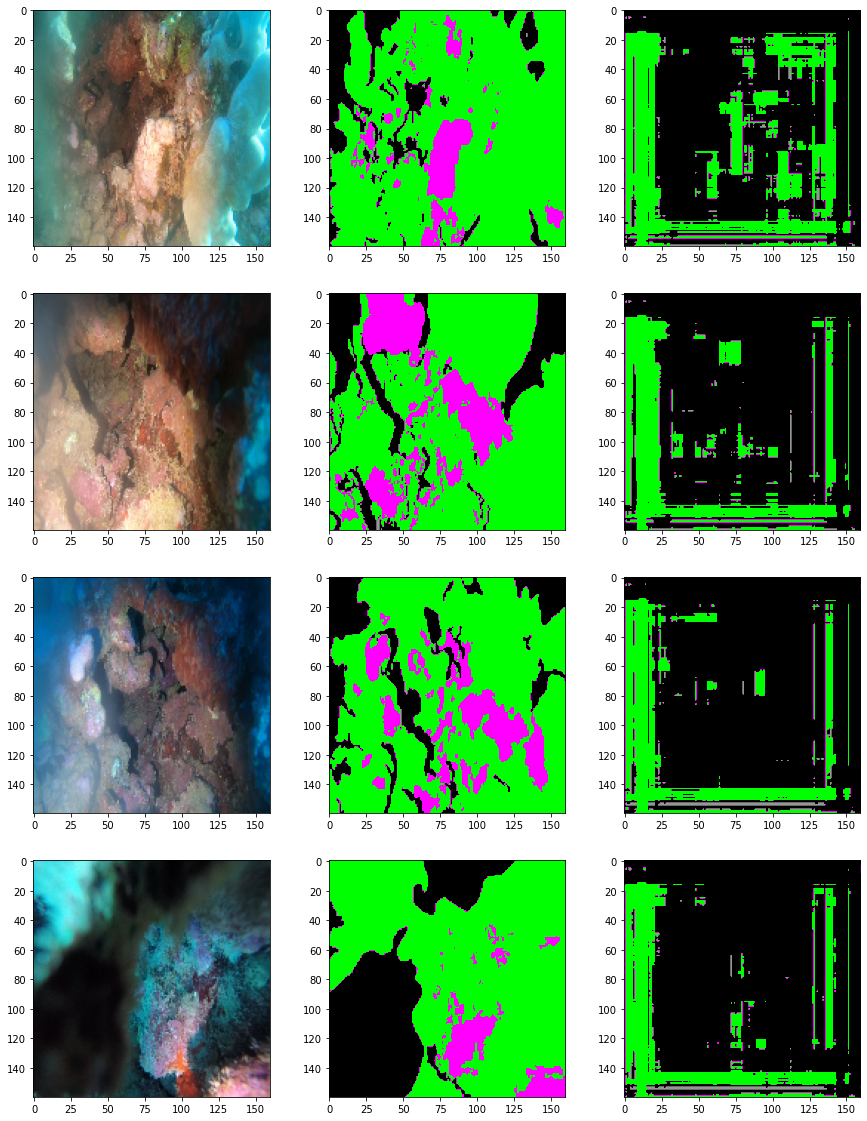

In [ ]:
# A color map object for matplotlib to map integer labels to colors
visualizer_cmap = colors.ListedColormap([(0, 1, 0), (1, 0, 1), (0, 0, 0)])

fig = plt.figure(figsize=(15, 20))  # width, height in inches
for i, e in enumerate(train_dataset.as_numpy_iterator()):
    sub = fig.add_subplot(4, 3, i * 3 + 1)
    sub2 = fig.add_subplot(4, 3, i * 3 + 2)
    sub3 = fig.add_subplot(4, 3, i * 3 + 3)
    test1 = e[0][0]
    testMask = e[1][0]
    pred = infer(model, test1)
    sub.imshow(np.array(test1 * 255, dtype="uint8"))
    sub2.imshow(testMask, cmap=visualizer_cmap)
    sub3.imshow(pred, cmap=visualizer_cmap)
    print("Train Image", i + 1)
    print(f"% of shadow pixels: {np.count_nonzero(pred == 0)}")
    print(f"% of CCA pixels: {np.count_nonzero(pred == 1)}")
    print(f"% of unclassed pixels: {np.count_nonzero(pred == 2)}")
    acc.update_state(testMask, pred)
    print(f"Accuracy: {acc.result().numpy()}\n")